# Projet_CD2
Projet de Maths du cours Calcul Différentiel II

In [1]:
#Importations
from mpl_toolkits.mplot3d import Axes3D
#import autograd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Amorce
Question : À quelle condition raisonnable portant sur $f(0, 0), f(0, 1)$ et le réel
$c$ est-on certain qu’il existe un $t \in [0, 1]$ tel que $f(0, t) = c$ ? Développer une
fonction qui renvoie un flottant éloigné d’au plus `eps` d’un tel `t` ou `None` si la condition
évoquée ci-dessus n’est pas satisfaite.

Il suffit que la fonction $t \longrightarrow f(0,t)$ soit continue sur $[0,1]$ (ce qui est le cas car $f$ est continûment différentiable), et que $(f(0,0)-c)(f(0,1)-c) <= 0$ pour appliquer le TVI.
Voir la fonction `find_seed(g, c=0, eps=2**(-26))`.



In [2]:
def find_seed(g, c=0, eps=2**(-26)):
    """Methode renvoyant un réel t de [0,1] tq g(t) = c.
    La fonction retourne une valueError si jamais (g(0)-c)(g(1)-c) > 0"""
    if (g(0)-c)*(g(1)-c) > 0:
        raise ValueError("Erreur : aucune garantie qu'un t tel que g(t) = c existe !")
    #On fait de la dichotomie car il faut travailler avec le eps
    return dicho(lambda t : g(t) - c,0,1,eps)

def dicho(g,a,b,eps):
    """Méthode récursive utilisant le principe de la dichotomie pour exploiter le TVI"""
    m = (a+b)/2
    if b-a <= 2*eps:
        return m
    elif g(a)*g(m) <= 0:
        return dicho(g,a,m,eps)
    else:
        return dicho(g,m,b,eps)
    
#Test
print(r"$\pi$ /6 = " + str(find_seed(np.sin, c=1/2)))

$\pi$ /6 = 0.523598775267601


## Propagation
On souhaite implémenter une fonction dont la signature est :

`def simple_contour(f, c=0.0, delta=0.01):
...
return x, y`


qui renvoie un fragment de ligne de niveau de valeur c de f, sous la forme
de deux tableaux 1d d’abscisses et d’ordonnées de points de cette ligne. Les
points devront être espacés d’approximativement delta. En cas d’impossibilité
de générer un tel fragment deux tableaux vides devront être renvoyés.

### Outils mathématiques à disposition
On commence par mettre en place les différents outils mathématiques dont nous allons avoir besoin

In [3]:
def grad(f):
    """Retourne la fonction grad(f)"""
    h = 10**(-10)
    return lambda x,y : np.array((f(x+h,y)-f(x,y), f(x,y+h)-f(x,y)))/h

def creerPlanTg(f, x0, y0):
    """Retourne une fonction donnant le plan tangent en f(x0, y0)"""
    gradFEnM = grad(f)(x0,y0)
    return lambda x,y : gradFEnM[0]*(x-x0) + gradFEnM[1]*(y-y0) + f(x0,y0)

### Premiers essais
Quelques test pour essayer de plot en 3D

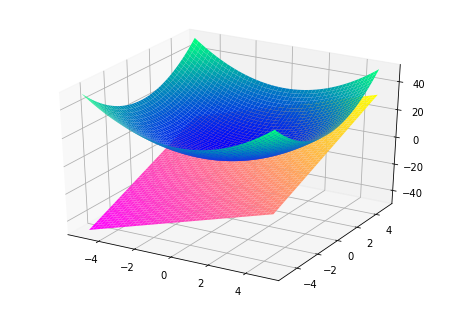

In [25]:
def f(x, y):
    """Fonction f avec laquelle on travaille"""
    return np.power(x,2) + np.power(y,2)

#Création du graphe en 3D
domain_x = np.linspace(-5, 5)   
domain_y = np.linspace(-5, 5)
X, Y = np.meshgrid(domain_x, domain_y)
fig = plt.figure()
ax = Axes3D(fig)

#On trace f
ax.plot_surface(X, Y, f(X, Y), cmap='winter')

#Test de tracé du plan tg en un point (x0,y0)
x0,y0 = 2,2
planEnM = creerPlanTg(f, x0, y0)
ax.plot_surface(X, Y, planEnM(X,Y), cmap='spring')

### Méthodologie
On va pour résoudre ce problème :
- commencer en partant d'un point $(x_0,0, z_0)$ trouvé sur l'arrête gauche en utilisant le TVI comme précédemment, où $z_0 = c$. On note ce point $M_0 = (x_0,y_0, z_0)$ avec donc $y_0 = 0$
- On va alors, pour créer le point $M_1 = (x_1,y_1, z_1)$, regarder la droite formée par l'intersection du plan tangent à $f$ en $M_0$ et le plan d'équation $z=c$. On trouve alors exactement deux points se situant à une distance $\delta$ de $M_0$, mais à moins d'être dans le cas particulier (donc impossible en pratique) ou la droite est parallèle à l'axe des abscisses, un seul de ces deux points possède une coordonnée $y$ positive. On note alors ce point $M_1$.
- On réutilise la même méthode pour construire ainsi par récurence la suite de points $(M_n)$ qui donne une bonne approximation de la courbe de niveau (approximation d'autant meilleur que $\delta$ est petit). Il n'y a jamais de problème de choix entre les deux points possibles sur la droite car l'un d'entre eux est $M_{n-1}$, donc il suffit de prendre l'autre.


Mathématiquement, la droite $D$ décrite ci dessus possède les caractéristiques suivantes :
$$\forall (x,y,z) \in D, \left\{
    \begin{array}{ll}
        \frac{\partial f}{\partial x}(M_0) \times (x-x_0) + \frac{\partial f}{\partial y}(M_0) \times (y-y_0) = 0 \\
        z - z_0 = 0
    \end{array}
\right.$$

Donc si l'on cherche les points éloignés de $\delta$ de $M_0$, ce qui se traduit par $(x-x_0)^2 + (y-y_0)^2 = \delta ^2$, on se retrouve à résoudre un système de la forme :
$$\lambda a + \mu b = 0 \text{ et } a^2 + b^2 = \delta ^2$$
Sous réserve que $\lambda$ et $\mu$ soient non nuls (toujours le cas en pratique, comme ce sont les coordonnées du gradient de $f$ en $M_0$), se système se résout et l'on trouve alors deux couples de solutions qui sont les suivants :

$$\left\{
    \begin{array}{ll}
        a = -\eta \mu \\
        b = \eta \lambda
    \end{array}
\right.
\text{ ou }
\left\{
    \begin{array}{ll}
        a = \eta \mu \\
        b = -\eta \lambda
    \end{array}
\right. 
\text{ avec } \eta = \frac{\delta}{\sqrt{\lambda^2 + \mu^2}}$$


On garde, pour le cas ou l'on cherche $M_1$, celle telle que $y_1 >0$, et pour les cas ou 'lon cherche $M_{n+1}$ celle qui n'est pas $M_{n-1}$.

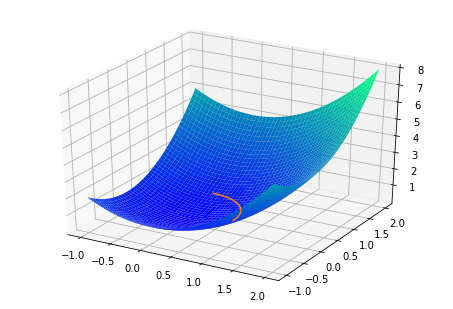

In [29]:
def simple_contour(f, c=0.0, delta=0.01):
    """Methode donnant la ligne de niveau de la fonction f a la hauteur c sur le domaine [0,1]^2
    Il est indispensable qu'il existe un point t tel que f(t,0) = c"""
    gradf = grad(f)
    #On cherche le point M0 du début
    ListeM = []
    ListeM.append((find_seed(lambda t : f(t,0), c), 0, c))
    
    #On trouve les deux points M1 possibles
    ListeM1 = ProchainsPointsPossibles(gradf, ListeM[0], c, delta)
    
    #On prend celui ayant une coordonnée y positive
    if ListeM1[0][1] >= 0:
        ListeM.append(ListeM1[0])
    else:
        ListeM.append(ListeM1[1])
        
    #On lance à présent la machine
    while True:
        #On trouve les prochains points possibles et on choisit le plus loin de Mn-1
        ListeMsuivant = ProchainsPointsPossibles(gradf, ListeM[-1], c, delta)
        Mnew = ChoisirPointPlusEloigne(ListeMsuivant, ListeM[-2])
        
        #On vérifie que le point est toujours dans le domaine
        if not DansLeDomaine(Mnew):
            break;
        else:
            ListeM.append(Mnew)
    return ListeM

def DansLeDomaine(M):
    """Vérifie si le point M est dans le domaine [0,1]^2"""
    if M[0] >= 0 and M[0] <= 1:
        if M[1] >= 0 and M[1] <= 1:
            return True
    return False
    
    
def ProchainsPointsPossibles(gradf, M, c, delta):
    gradfEnM = gradf(M[0],M[1])
    l = gradfEnM[0]
    mu = gradfEnM[1]
    
    eta = delta/(np.sqrt(l**2 + mu**2))
    
    return ((M[0] - eta*mu, M[1] + eta*l, c),(M[0] + eta*mu, M[1] - eta*l, c))


def ChoisirPointPlusEloigne(ListeM, MRepere):
    """Retourne parmi une liste de 2 points ListeM le plus éloigné de MRepere"""
    a = (ListeM[0][0] - MRepere[0])**2 + (ListeM[0][1] - MRepere[1])**2
    b = (ListeM[1][0] - MRepere[0])**2 + (ListeM[1][1] - MRepere[1])**2
    if a > b:
        return ListeM[0]
    else:
        return ListeM[1]

#Premier essais
L = simple_contour(f, c=f(0.8,0)) 

#Création du graphe en 3D
domain_x = np.linspace(0, 1)   
domain_y = np.linspace(0, 2)
X, Y = np.meshgrid(domain_x, domain_y)
fig = plt.figure()
ax = Axes3D(fig)

#On trace f
ax.plot_surface(X, Y, f(X, Y), cmap='winter')

#On trace la courbe de niveau
ax.plot([M[0] for M in L], [M[1] for M in L], [M[2] for M in L])